In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [ ]:
!wget https://github.com/shchur/shchur.github.io/raw/gh-pages/assets/notebooks/tpp2/toy_dataset.pkl

--2024-05-09 18:06:14--  https://github.com/shchur/shchur.github.io/raw/gh-pages/assets/notebooks/tpp2/toy_dataset.pkl
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shchur/shchur.github.io/gh-pages/assets/notebooks/tpp2/toy_dataset.pkl [following]
--2024-05-09 18:06:15--  https://raw.githubusercontent.com/shchur/shchur.github.io/gh-pages/assets/notebooks/tpp2/toy_dataset.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 622639 (608K) [application/octet-stream]
Saving to: ‘toy_dataset.pkl’

toy_dataset.pkl     100%[===================>] 608.05K  --.-KB/s    in 0.03s   

2024-05-09 18:06:15 (2

In [ ]:
data = torch.load("toy_dataset.pkl")
# arrival_times_list is a list of variable-length lists
# arrival_times_list[j] is the list of arrival times of sequence j
arrival_times_list = data["arrival_times"][:5]
# t_end = length of the observerd time interval [0, t_end]
t_end = data["t_end"]
seq_lengths = torch.tensor([len(t) for t in arrival_times_list], dtype=torch.long)

def get_inter_times(t, t_end):
    tau = np.diff(t, prepend=0.0, append=t_end)
    return torch.tensor(tau, dtype=torch.float32)

from torch.nn.utils.rnn import pad_sequence
inter_times_list = [get_inter_times(t, t_end) for t in arrival_times_list]
inter_times = pad_sequence(inter_times_list, batch_first=True)


#Loop to correct the t_end

max_end = 0
for l in arrival_times_list:
  m = max(l)
  if m > max_end:
    max_end = m

t_end = max_end if t_end != max_end else t_end

''

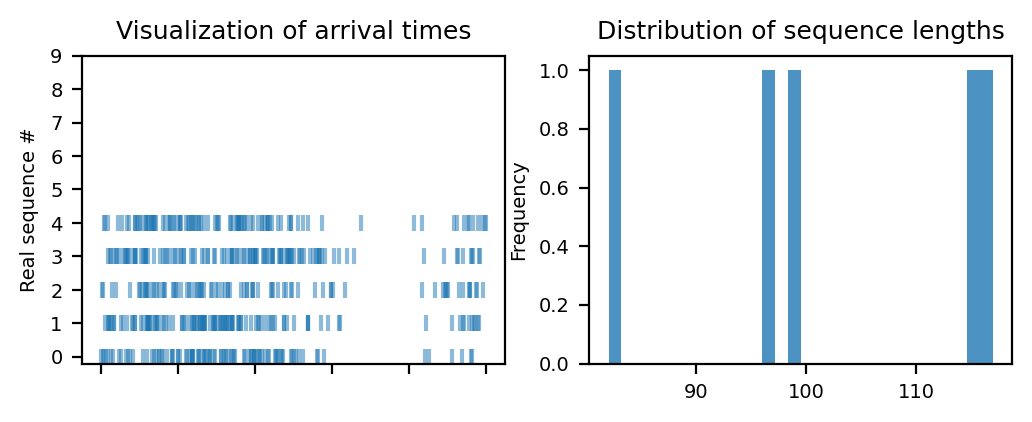

In [ ]:

fig, axes = plt.subplots(figsize = (6,2), dpi=200, nrows=1, ncols=2)
plt.subplots_adjust(hspace=0.1)
for idx, t in enumerate(arrival_times_list[:10]):
    axes[0].scatter(t, np.ones_like(t) * idx, alpha=0.5, c='C0', marker="|")
axes[0].set_ylabel("Real sequence #", fontsize=7)
axes[0].set_yticks(np.arange(10));
axes[0].set_title("Visualization of arrival times", fontsize=9)


# for idx, t in enumerate(generated_sequences[:10]):
#     axes[1, 0].scatter(t, np.ones_like(t) * idx, alpha=0.5, c='C1', marker="|")
# axes[1, 0].set_xlabel("Time", fontsize=7)
# axes[1, 0].set_ylabel("Generated sequence #", fontsize=7)
# axes[1, 0].set_yticks(np.arange(10))
axes[0].set_xticklabels([])

for ax in np.ravel(axes):
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)

axes[1].set_title("Distribution of sequence lengths", fontsize=9)
# q_min = min(seq_lengths.min(), gen_seq_lengths.min())
# q_max = max(seq_lengths.max(), gen_seq_lengths.max())
axes[1].hist(seq_lengths, 30, alpha=0.8, color="C0", label="Real data");
axes[1].set_ylabel("Frequency", fontsize=7)
# axes[1].set_xticklabels([])

# axes[1, 1].hist(gen_seq_lengths, 30, alpha=0.8, color="C1", range=(q_min, q_max), label="Generated by the model");
# axes[1, 1].set_xlabel(r"Sequence length", fontsize=7)
# axes[1, 1].set_ylabel("Frequency", fontsize=7)

# fig.legend(loc="lower center", ncol=2, fontsize=7)
;

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ToyDataset(Dataset):

  def __init__(self, inter_times, seq_lengths = None):

    self.inter_times = inter_times
    self.seq_lengths = seq_lengths

  def __getitem__(self, idx, operation = None):

    if operation is None:
      operation = self.option2

    data = self.inter_times[idx]
    data = operation(data, self.inter_times)
    data[idx] = self.inter_times[idx]
    data = data[..., np.newaxis]
    logdata = np.log(self.inter_times.clamp_min(1e-8))
    logdata = operation(logdata[idx], logdata)
    logdata[idx] = np.log(self.inter_times[idx].clamp_min(1e-8))
    logdata = logdata[..., np.newaxis]

    data = np.concatenate((data,logdata), axis = -1)

    return data

  def __len__(self):
    return len(self.inter_times)


  def option1(self, A, B):
    diff = np.where(A > B, A - B, -1)
    return diff

  def option2(self, A, B):
    diff = np.where(A > B, B, -1)
    return diff



In [ ]:
def option2(A, B):
    diff = np.where(A > B, B, -1)
    return diff

In [ ]:
def option1(self, A, B):
  diff = np.where(A > B, A - B, -1)
  return diff

In [ ]:
idx = np.searchsorted(A, B)
A[:idx[2]]

[1, 2, 3]

In [ ]:
idx

array([0, 0, 3])

In [ ]:
A = [1, 2, 3]
B = [0.1, 1, 4]

In [ ]:
print(option2(A,B))

[0.1 1.  4. ]


In [ ]:
dataset = ToyDataset(inter_times)

In [ ]:
dataset[0].shape

(5, 118, 2)

In [ ]:
dataset[0][:, :, 0]

array([[ 1.44208176e-02,  4.27717149e-01,  1.52472615e-01,
         5.78801990e-01,  7.02908397e-01,  7.25462079e-01,
         3.43802929e-01,  1.60127997e+00,  5.94259739e-01,
         1.24701691e+00,  6.17733479e-01,  5.45273304e-01,
         6.71486855e-01,  2.51991081e+00,  1.18450069e+00,
         1.19730377e+00,  6.72862053e-01,  5.32954216e-01,
         6.35132790e-01,  1.52523994e-01,  7.26883888e-01,
         2.39674568e-01,  9.38558578e-01,  1.32156563e+00,
         3.36189270e-02,  2.11894989e-01,  1.34263229e+00,
         1.36394501e-02,  5.75258255e-01,  1.43075180e+00,
         3.63166809e-01,  7.52037048e-01,  4.48976517e-01,
         1.58872604e-01,  1.07460022e-02,  8.20541382e-02,
         1.76616669e-01,  1.21767044e+00,  1.53942108e-01,
         9.51061249e-02,  9.21695709e-01,  4.70464706e-01,
         1.93401337e-01,  2.36190796e-01,  8.53645325e-01,
         1.57526016e-01,  5.45310974e-03,  1.18449402e+00,
         2.38073349e-01,  1.39271545e+00,  1.49578094e-0

In [ ]:
s = torch.rand(size = (20,2))

In [ ]:
s = nn.Parameter(torch.rand(size = (7,7)))
s

Parameter containing:
tensor([[0.2190, 0.2928, 0.0011, 0.4320, 0.1106, 0.9346, 0.0048],
        [0.1392, 0.7697, 0.2311, 0.9370, 0.8183, 0.1073, 0.4084],
        [0.0287, 0.2822, 0.3622, 0.1670, 0.1670, 0.7881, 0.3200],
        [0.5690, 0.8709, 0.5652, 0.2596, 0.4998, 0.8623, 0.6747],
        [0.4661, 0.8011, 0.6367, 0.3776, 0.4680, 0.9831, 0.2253],
        [0.8982, 0.3751, 0.9044, 0.3106, 0.7784, 0.6360, 0.9999],
        [0.0443, 0.4576, 0.1381, 0.7646, 0.7155, 0.9583, 0.6987]],
       requires_grad=True)

In [ ]:
class MPPFlow(nn.Module):

    def __init__(self, flows, num_processes : int = 2):
        """
        Inputs:
            flows - A list of flows (each a nn.Module) that should be applied on the images.
        """
        super().__init__()

        self.flows = flows
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        self.num_processes = num_processes
        self.W = nn.Parameter(torch.rand(size = (num_processes, num_processes, 2)))
        # torch.nn.init.xavier_uniform_(self.W)
        self.gumbel_softmax = torch.nn.functional.gumbel_softmax

    # def forward(self, x, idx):
    #     # The forward function is only used for visualizing the graph
    #     return self._get_likelihood(x, idx)

    def encode(self, x, idx):
        # Given a batch of images, return the latent representation z and ldj of the transformations
        z, ldj = x, torch.zeros(x.shape[0])
        for flow in self.flows[idx]:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, x, idx):

        z, ldj = self.encode(x, idx)
        log_pz = self.prior.log_prob(z).sum(dim=[1]) ## (B, 2)
        #print(log_pz.shape, ldj.shape, z.shape)
        log_px = ldj.unsqueeze(-1) + log_pz
        nll = -log_px
        W = self.gumbel_softmax(self.W[idx]) ## (B, 2)
        #W = self.W[idx] ## (B, 2)

        loss = nll*W ## (B, 2)

        return loss


    def train(self, dataset, epochs, lr = 1e-2):

      assert self.num_processes == len(dataset)

      optimizers = [torch.optim.Adam(self.flows[i].parameters(), lr = lr) for i in range(self.num_processes)]

      losses = np.zeros(shape = (self.num_processes, epochs))

      for epoch in range(epochs):
        for idx, process in enumerate(dataset):
          optimizer = optimizers[idx]

          optimizer.zero_grad()

          X = torch.from_numpy(process)

          loss = (self._get_likelihood(X, idx).sum(axis = 1)).mean()
          loss.backward()

          losses[idx, epoch] = loss.item()

          optimizer.step()
        print(f'Mean MPP {losses[:, epoch].mean()}, Max {losses[:, epoch].max()}, Min {losses[:, epoch].min()}, Std {losses[:, epoch].std()} ' )

      return losses









In [ ]:
### (B, L, 2)

Batchsize should be num_process - 1
If batchsize less than num_proccesses, careful when computing the W*nll

In [ ]:
def line_mask(seq_len : int, invert : bool = False):
  mask = torch.tensor([1 - (i % 2) for i in range(seq_len)], dtype = torch.float)#.to(device)
  mask = mask.unsqueeze(0).unsqueeze(2)

  if invert:
    mask = 1 - mask

  return mask

def column_mask(seq_len : int, features : int = 2, invert : bool = False):
  mask = torch.zeros((seq_len, features))
  mask[::2, ::2] = 1
  mask[1::2, 1::2] = 1

  mask = mask.unsqueeze(0)
  if invert:
    mask = 1 - mask

  return mask

In [ ]:
class Network(nn.Module):
  def __init__(self, in_features : int = 2, out_features : int = 4, hidden_dim : int = 32):
    super().__init__()

    self.embedding = nn.Sequential(
        nn.Linear(in_features = 2, out_features = hidden_dim),
        nn.ReLU(inplace = True)
    )

    self.gru = nn.GRU(input_size = hidden_dim, hidden_size = hidden_dim, num_layers = 4, batch_first = True)

    self.final = nn.Linear(in_features = hidden_dim, out_features = out_features)

  def forward(self, x):
    x = self.embedding(x)
    out, hd = self.gru(x)
    out = self.final(out)
    return out

In [ ]:
model = Network()

In [ ]:
class CouplingLayer(nn.Module):

    def __init__(self, network, mask, in_features : int = 2):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            in_features - Number of input channels
        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(in_features))
        self.register_buffer('mask', mask)

    def forward(self, z, ldj, reverse=False):
        """
        Inputs:
            z - Latent input to the flow
            ldj - The current ldj of the previous flows.
                  The ldj of this layer will be added to this tensor.
            reverse - If True, we apply the inverse of the layer.
            orig_img (optional) - Only needed in VarDeq. Allows external
                                  input to condition the flow on (e.g. original image)
        """
        # Apply network to masked input
        z_in = z * self.mask

        nn_out = self.network(z_in)

        s, t = nn_out.chunk(2, dim=2)

        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, 1, -1)
        s = torch.tanh(s / s_fac) * s_fac

        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1,2])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1,2])

        return z, ldj

In [ ]:
def print_num_params(model):
    num_params = sum([np.prod(p.shape) for p in model.parameters()])
    print("Number of parameters: {:,}".format(num_params))

In [ ]:
def create_mpp_flow(num_processes : int = 2):
  flow_list = []
  for k in range(num_processes):
    flow_layers = []
    for i in range(4):
        flow_layers += [CouplingLayer(network=Network(),
                                      mask=column_mask(seq_len = 118, features = 2, invert=(i%2==1)))]

    flow_layers = nn.ModuleList(flow_layers)

    flow_list.append(flow_layers)

  flow_list = nn.ModuleList(flow_list)
  flow_model = MPPFlow(flow_list, num_processes = len(flow_list))
  return flow_model

In [ ]:
teste = create_mpp_flow(num_processes = 5)#20)

In [ ]:
print_num_params(teste)

Number of parameters: 511,530


In [ ]:
5x118

In [ ]:
losses[:, -1]

array([ 81.61886597, 108.68391418, -19.46912575, 230.65103149,
        36.44798279])

In [ ]:
losses = teste.train(dataset = dataset, epochs = 50)

Mean MPP 1594.8690063476563, Max 2786.9169921875, Min 572.0101318359375, Std 835.4956503624082 
Mean MPP 363.64793090820314, Max 400.0946960449219, Min 333.4940185546875, Std 25.03245341445995 
Mean MPP 362.77301025390625, Max 407.20123291015625, Min 321.63861083984375, Std 35.69326925355047 
Mean MPP 333.211083984375, Max 352.99285888671875, Min 301.2433166503906, Std 20.046401280318054 
Mean MPP 338.5907958984375, Max 389.27386474609375, Min 283.5782775878906, Std 39.089307104417095 
Mean MPP 341.9565734863281, Max 380.5540466308594, Min 319.9336853027344, Std 22.36989335458426 
Mean MPP 334.1999877929687, Max 395.1683044433594, Min 266.27972412109375, Std 46.708540459976895 
Mean MPP 305.72060546875, Max 344.5853576660156, Min 238.95266723632812, Std 35.30852663526393 
Mean MPP 280.4671905517578, Max 366.8910827636719, Min 200.60202026367188, Std 60.19076232594224 
Mean MPP 265.9868408203125, Max 309.72564697265625, Min 180.33987426757812, Std 45.512947268155 
Mean MPP 250.902810668

In [ ]:
losses[:, -1]

array([ 81.61886597, 108.68391418, -19.46912575, 230.65103149,
        36.44798279])

In [ ]:
W_to_plot = torch.nn.functional.gumbel_softmax(teste.W, dim = 1).detach().cpu().numpy()

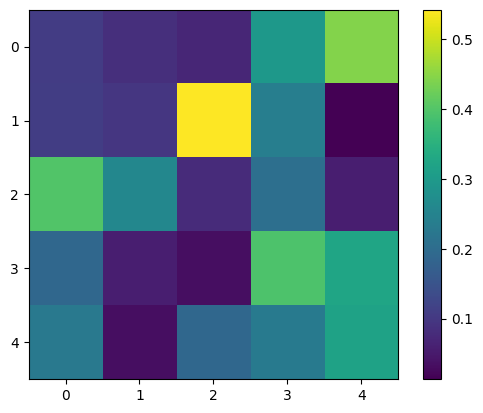

In [ ]:
fig = plt.imshow(W_to_plot[:, :, 0])
plt.colorbar(fig);

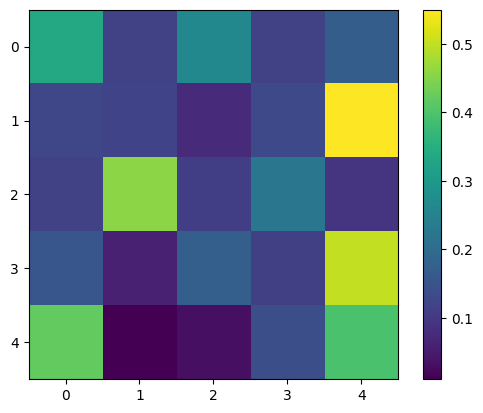

In [ ]:
fig = plt.imshow(W_to_plot[:, :, 1])
plt.colorbar(fig);

In [ ]:
W_to_plot = torch.nn.functional.gumbel_softmax(teste.W, dim = 1).detach().cpu().numpy()

In [ ]:
(5,118,2) - (118, 5, 118, 2)

## Todo

Pegar o historico de maneira correta.
torch. searchsorted
Financial data - ticks
Dado simulado.
(5,118,2) - (118, 5, 118, 2).
EM algorithm - Flavio; numba jit
torch.vmap
Flow Autogressive



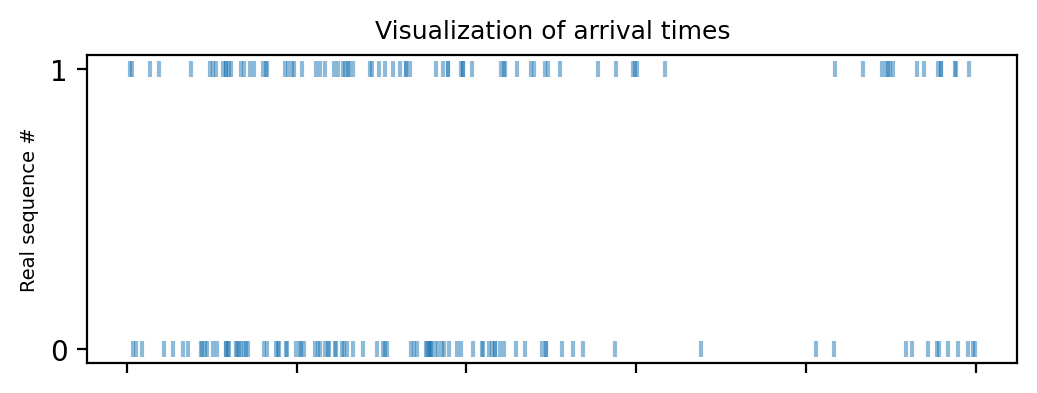

In [ ]:
ss = [arrival_times_list[4], arrival_times_list[2]]
fig, axes = plt.subplots(figsize = (6,2), dpi=200, nrows=1, ncols=1)
plt.subplots_adjust(hspace=0.1)
for idx, t in enumerate(ss):
    axes.scatter(t, np.ones_like(t) * idx, alpha=0.5, c='C0', marker="|")

axes.set_ylabel("Real sequence #", fontsize=7)
axes.set_yticks(np.arange(2));
axes.set_title("Visualization of arrival times", fontsize=9)
axes.set_xticklabels([]);


In [ ]:
ss = [arrival_times_list[11], arrival_times_list[5]]
fig, axes = plt.subplots(figsize = (6,2), dpi=200, nrows=1, ncols=1)
plt.subplots_adjust(hspace=0.1)
for idx, t in enumerate(ss):
    axes.scatter(t, np.ones_like(t) * idx, alpha=0.5, c='C0', marker="|")

axes.set_ylabel("Real sequence #", fontsize=7)
axes.set_yticks(np.arange(2));
axes.set_title("Visualization of arrival times", fontsize=9)
axes.set_xticklabels([]);


IndexError: list index out of range